In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys 
from atol import Atol
from heat_kernel_homology import GeneralFiltrationGraphHomology
import numpy as np
import networkx as nx
import pandas as pd
from pysmiles import read_smiles

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from networkx.convert_matrix import to_numpy_matrix
from utils import blockPrinting, plot_diagram

%load_ext autoreload
%autoreload 2

## Data load

We use the ClinTox dataset which contains the data of drugs approved by the FDA and those that have failed clinical trials for toxicity reasons.

In [2]:
df = pd.read_csv('./data/clintox/clintox.csv')

In [3]:
df.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


Smiles are a standard way of encoding chemical information into a string. For further information and for a dictionary of the characters used visit the following [link](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system).

## Smiles converted into Graph

We are going to analyze the problem in two different ways: in the first case we threat the **drugs molecules** as **graphs** (each atom is a node and the edges corresponds to chemical bounds), considering only the structure of the molecules (the information about the node elements is not considered in this part); in the second example we also add chemical information as *composition* and *stereoisomerism*.

In [4]:
@blockPrinting
def convert_smiles(smiles):
    return [to_numpy_matrix(read_smiles(smile, explicit_hydrogen=False, 
                                        zero_order_bonds=True, 
                                        reinterpret_aromatic=True)) 
            for smile in smiles]

In [5]:
df['smiles_graph'] = convert_smiles(df.smiles)

In [6]:
df.head()

,smiles,FDA_APPROVED,CT_TOX,smiles_graph
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0,[[[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0,"[[[[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]]]], ..."
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0,[[[[[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1....
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0,[[[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0,[[[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....


Here we show an example of conversion from **SMILES** to **graph**.

I don't quite know how to handle stereo yet...
*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC


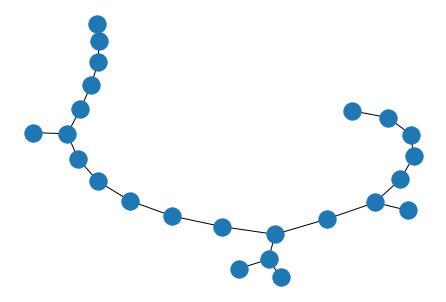

In [7]:
smile = df.smiles.iloc[0]
graph = read_smiles(smile, explicit_hydrogen=False, zero_order_bonds=True, 
                    reinterpret_aromatic=True)
print(smile)
nx.draw(graph)

## From Graph to diagrams with HKS

From the graphs we compute persistence diagrams. The time parameter in the HKS algorithm can be consider as a kind of **scale** parameter!

In [8]:
hkh = GeneralFiltrationGraphHomology(time=.1, n_jobs=-1)
diagrams_hkh_01 = hkh.fit_transform(df.smiles_graph)

In [9]:
hkh = GeneralFiltrationGraphHomology(time=10, n_jobs=-1)
diagrams_hkh_10 = hkh.fit_transform(df.smiles_graph)

In [10]:
hkh = GeneralFiltrationGraphHomology(time=1, n_jobs=-1)
diagrams_hkh_1 = hkh.fit_transform(df.smiles_graph)

In [11]:
diagrams_hkh_10[:, :, -1] = diagrams_hkh_10[:, :, -1] + 4
diagrams_hkh = np.concatenate([diagrams_hkh_01, diagrams_hkh_10], axis=1)

Note that the HKS agorithm gives as output 4 subdiagrams that for seek of simplicity we encoded in the giotto-framework in the same way as different homology dimensions!

In [12]:
len(df)

1484

In [13]:
df.CT_TOX.mean()

0.07547169811320754

The dataset is highly unbalanced, with 92.5% of the molcules that are safe drugs and only 7.5% of them labeled as toxic. Thus, the accuracy is not a good metric for this kind of tasks, and for this reason we chose to use the AUC-ROC metric as measure of the performance of our model.

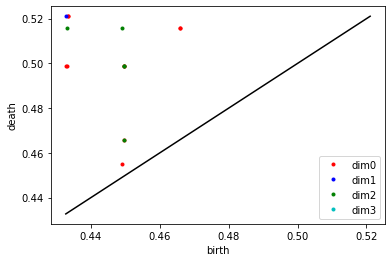

In [14]:
plot_diagram(diagrams_hkh_1[0])

The picture above represents an exemple of diagram used for feeding ATOL. The HKS algorithm gives as output 4 subdiagrams. Note that in the plot we used the terminology dim0, dim1, dim2, dim3 only in order to distinguish the four subplots. They are not to be considered as Homology dimensions in the real TDA meaning!

In [15]:
def add_chemical_info(smiles):
    stereo = np.zeros(3)
    for char in smiles:
        if char in '/':
            stereo[0] +=1
        if char in '@':
            stereo[2] += 1
        if char in '\\':
            stereo[1] += 1
    chemical_el = 'B C N O P S F Cl Br I * b c n o s p'.split()
    chemicals = np.zeros(len(chemical_el))
    smiles = '|'+smiles+'|'
    for i, el in enumerate(chemical_el):
        if el != 'C':
            chemicals[i] += len(smiles.split(el)) - 1
        else:
            chemicals[i] += len(''.join(smiles.split('Cl')).split(el)) - 1
    return np.concatenate([chemicals, stereo])

In [16]:
df['chemistry'] = df.smiles.apply(add_chemical_info)

In [17]:
df.head()

,smiles,FDA_APPROVED,CT_TOX,smiles_graph,chemistry
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0,[[[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[0.0, 14.0, 2.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0,"[[[[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]]]], ...","[0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, ..."
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0,[[[[[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1....,"[0.0, 6.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0,[[[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[0.0, 10.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0,[[[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[0.0, 7.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## We split the dataset in train and test

In [18]:
diag_train, diag_test, ext_feat_train, ext_feat_test, y_train, y_test = train_test_split(diagrams_hkh, df.chemistry, 
                                                                                         df.CT_TOX, test_size=0.2,
                                                                                         random_state=52, 
                                                                                        )

## Cross Validation for Simple Atol usage

In [19]:
def cross_validate(parameters, X, y, k_fold=5, **atol_params):
    set_up = []
    for parameter in parameters:
        pipeline_model = Pipeline([('atol_layer', Atol(parameter, **atol_params)), 
                                   ('model', RandomForestClassifier(n_estimators=100))])
        set_up.append((parameter, cross_val_score(pipeline_model, X, y, scoring='roc_auc', cv=k_fold)))
    return set_up

We get a 5-fold cross validation accuracy estimation for the simpler model using ATOL! Note in this exemple only notions about the structure of the molecules are used! **No chemical info**

In [20]:
cv_res_hkh = cross_validate(np.arange(1, 25).astype(int), diag_train, y_train, 
                            5, padding=0, ignore_hom_dim=False)

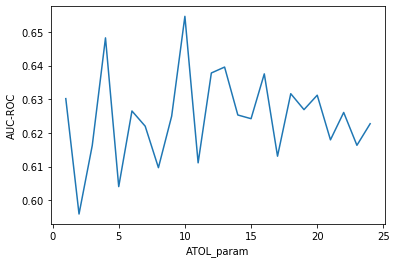

In [21]:
cv_res_mean_hkh = [(x, y.mean()) for x, y in cv_res_hkh]
plt.plot([x[0] for x in cv_res_mean_hkh], [x[1] for x in cv_res_mean_hkh])
plt.xlabel('ATOL_param')
plt.ylabel('AUC-ROC')
plt.show()

The best ATOL parameter according to the 5-fold cross validation is n_centers=23

In [22]:
best_parameter = np.arange(1, 25).astype(int)[np.argmax([x[1] for x in cv_res_mean_hkh])]
best_model = Pipeline([('atol_layer', Atol(best_parameter, padding=0, ignore_hom_dim=False)), 
                       ('model', RandomForestClassifier(n_estimators=100))])
best_model.fit(diag_train, y_train)
test_accuracy = roc_auc_score(y_test, best_model.predict_proba(diag_test)[:, 1])

In [23]:
test_accuracy

0.7243498817966902

## Features for more complex Atol usage

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin, ClusterMixin
from atol import lapl_feats

class AtolX(BaseEstimator, ClusterMixin, TransformerMixin):
    def __init__(self, n_centers=5, cluster_model=None, method=lapl_feats, aggreg=np.sum, order=None,
                 ignore_hom_dim=False, padding=None, external=True, n_jobs=None):
        self.atol = Atol(n_centers, cluster_model, method, aggreg, order, 
                         ignore_hom_dim, padding, n_jobs)
        self.external = external
    
    def fit(self, X, y=None):
        if self.external:
            ex = np.array([x[1] for x in X])
            X = np.array([x[0] for x in X])
        self.atol.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        if self.external:
            ex = np.array([x[1] for x in X])
            X = np.array([x[0] for x in X])
        Xt = self.atol.transform(X, y)
        return np.concatenate([ex, Xt], axis=1)
    
    def get_params(self, **params):
        atol_params = self.atol.get_params(**params)
        atol_params['external'] = self.external
        return atol_params

In [25]:
def cross_validate_with_ext(parameters, X, y, k_fold=5, **atol_params):
    set_up = []
    for parameter in parameters:
        pipeline_model = Pipeline([('atol_layer', AtolX(n_centers=parameter, **atol_params)),
                                   ('model', GradientBoostingClassifier(n_estimators=100))])
        set_up.append((parameter, cross_val_score(pipeline_model, X, y, scoring='roc_auc', cv=k_fold)))
    return set_up

In [26]:
external_diags_train = [(diag, ex) for diag, ex in zip(diag_train, ext_feat_train)]

In [27]:
external_diags_test = [(diag, ex) for diag, ex in zip(diag_test, ext_feat_test)]

In [28]:
cv_res_hkh = cross_validate_with_ext(np.arange(1, 25).astype(int), external_diags_train, y_train, 
                                     5, padding=0, ignore_hom_dim=False)

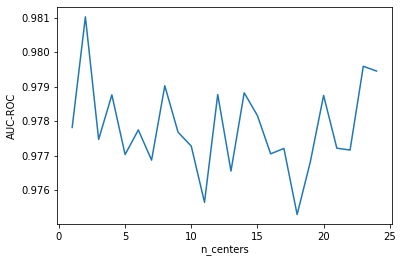

In [29]:
cv_res_mean_hkh = [(x, y.mean()) for x, y in cv_res_hkh]
plt.plot([x[0] for x in cv_res_mean_hkh], [x[1] for x in cv_res_mean_hkh])
plt.xlabel('n_centers')
plt.ylabel('AUC-ROC')
plt.savefig('cv_output.png')
plt.show()

In [30]:
best_parameter = np.arange(1, 25).astype(int)[np.argmax([x[1] for x in cv_res_mean_hkh])]
best_model = Pipeline([('atol_layer', AtolX(best_parameter, padding=0, ignore_hom_dim=False)), 
                       ('model', GradientBoostingClassifier(n_estimators=100))])
best_model.fit(external_diags_train, y_train)
test_accuracy = roc_auc_score(y_test, best_model.predict_proba(external_diags_test)[:, 1])

In [31]:
test_accuracy

0.9773049645390071

## only using classical features

In [32]:
X_tot = np.concatenate([x.reshape(1, -1) for x in df.chemistry], axis=0)

In [33]:
X_tot.shape

(1484, 20)

In [34]:
model = GradientBoostingClassifier(n_estimators=100)

In [35]:
cv_out = cross_val_score(model, X_tot, df.CT_TOX, scoring='roc_auc', cv=5)

In [36]:
np.mean(cv_out)

0.9581783560774356